# 基于编码器和解码器的时间序列预测

In [1]:
import datetime as dt
import os
import warnings
from collections import UserDict
from tqdm import tqdm # 打印进度条

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split

# 两种绘图接口
import plotly_express as px  
import plotly.graph_objects as go

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## 编码-解码器

编码—解码模型主要由编码器和解码器组成，编码器和解码器实际上都是一个神经网络，如下图：

![hello](../images/p24.jpg)

### 编码器

编码器内部由一个输入层和多层RNN（或LSTM）单元构成。

编码器没有输出层，但我们可以将其中RNN的内部状态作为输出。因为经过多层RNN的处理，RNN的内部状态已经可以充分代表源语言的含义。

在一些应用场合，如果将编码器所有神经元的状态都作为编码输出给解码器，复杂度会非常高，因此，人们会将最后一层的编码器状态作为对整个输入信息的编码。之所以选择最后一层，是因为这一层通常是对所有输入信息和低层隐含单元的信息汇总。



![hello](../images/p25.jpg)

### 解码器

解码器的架构和编码器大体相同。

我们已经知道，编码器和解码器之间需要通过内部状态进行连接，我们将内部状态定义为，在完成对中文的编码后编码器内网络全部隐含神经元状态的取值。而在解码器中，我们也定义了相同结构的RNN。因此，我们采用的连接方式是使用编码器RNN的内部状态来初始化解码器RNN的初始状态。实际上，这个过程并非直接采用编码器的输出作为解码器的输入，而是将编码器中每一个神经元的值都直接赋给解码神经元作为初始值。

因此，将解码器的初始状态设定为编码器的最终状态，既可以在编码器与解码器之间建立连接，驱动解码器的运转，又避免了解码器中所有隐含节点被全零初始化或随机初始化，大大节省了训练解码器的时间。

![hello](../images/p26.jpg)

解码器内部的RNN架构与编码器内部的RNN架构相同，我们只需将编码器内部RNN的状态直接赋值给解码器内部的RNN，即可实现内部状态的传递。

解码器与编码器不同的地方在于，解码器需要对应到输出层，也需要使用交叉熵方法来计算网络的损失。由于我们已经将编码器和解码器连接为一个整体的动态计算图，因此神经网络的反馈调整可以由PyTorch自动进行。

我们可以这样理解编码器和解码器的作用：编码器实现的是对源信息的理解，解码器实现的是对内部状态到目标信息的映射，而模型整体可以实现源信息到目标信息的“翻译”。

## 自编码器

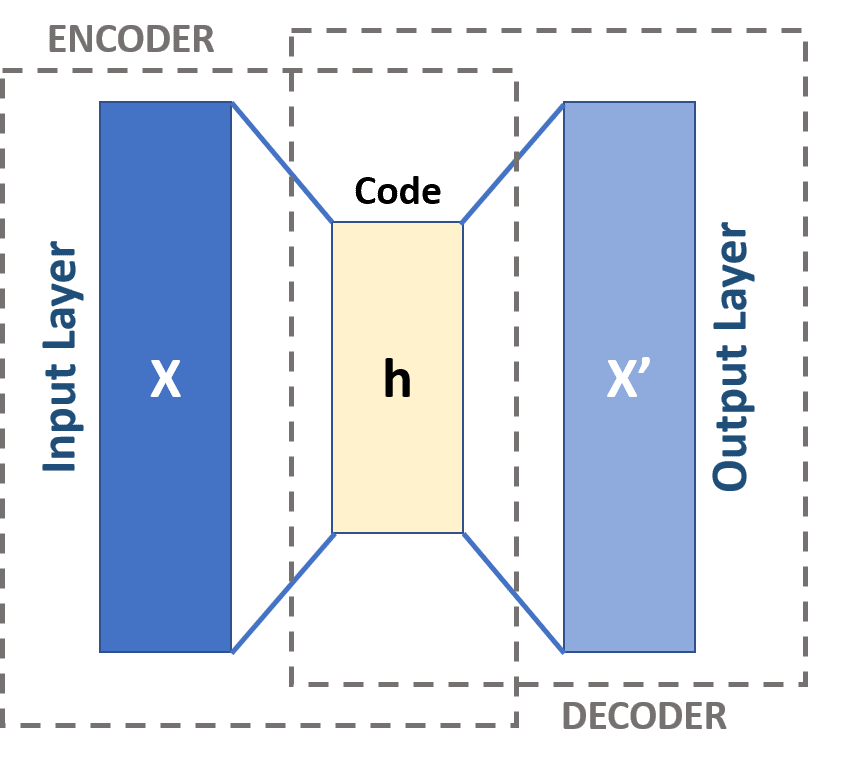

1986年Rumelhart提出自编码器的概念，顾名思义，即可以使用自身的高阶特征编码自己。自编码器（auto-encoder, AE）是一类在半监督学习和无监督学习中使用的人工神经网络（Artificial Neural Networks, ANNs），其功能是通过将输入信息作为学习目标，对输入信息进行表征学习。 

其结构通常包括一个输入层、一个或多个隐藏层和一个输出层。自编码器的目标是学习将输入数据压缩到隐藏层中，并能够通过解码器将其从压缩表示中重建出输入数据。

自编码器基本上可以分为三个不同的组件：编码器、瓶颈和解码器。编码器将输入数据映射到隐藏层，通常通过一系列的非线性变换和特征提取来实现。解码器则将隐藏层的表示映射回到重构的输入数据，同时也通过非线性变换和特征提取来实现。自编码器通过将输入数据进行压缩和重建的过程来学习有效的数据表示，从而可以用于数据的降维、特征提取、数据压缩、数据去噪等应用。

如果自编码器只是单纯的将输入复制到输出中，那么他没有用处。所以实际上，希望通过训练自编码器将输入复制到输出中，使隐藏表示的 h 拥有有用的属性。

因为自编码器也是一种神经网络，它的输入和输出是一致的，它借助稀疏编码的思想，目标是使用一些高阶特征重新组合来重构自己，即对所有的自编码器来讲，目标都是**样本重构**。自编码器首先通过编码层，将高维空间的向量压缩成低维的向量（潜在变量），然后通过解码层将低维向量解压重构出原始样本。

假如我们通过一组数据训练出了我们的自编码器，然后我们拆掉自编码器的解码器，就可以用剩下的编码器来表征我们的数据了。隐藏层的神经元数目远低于输入层，那么就相当于我们用更少的特征（神经元）去表征我们的输入数据，从而达到**降维压缩**的功能。

自编码器（Autoencoder）通常**不需要时间步**（time steps），因为自编码器主要用于学习数据的紧凑表示，而不涉及到时序信息。自编码器的训练通常是在整个输入数据集上进行的，而不是在时间序列数据上按照时间步进行。

如果你的数据是时序数据，并且你关心时间信息，你可能会考虑使用递归神经网络（Recurrent Neural Network，RNN）或长短时记忆网络（Long Short-Term Memory，LSTM）等网络结构，这些结构被设计用于处理时序信息。**自编码器通常用于静态数据或无序数据的表示学习，而不是处理时序信息。**

## 编码-解码器和自编码器区别

**任务目标：**

- 自编码器： 主要用于学习输入数据的紧凑表示，并能够通过解码器生成与原始输入相似的输出。训练目标通常是最小化输入和重构输出之间的差异。
- 编码-解码器： 这是一个更一般性的框架，可以用于执行多种任务，而不仅仅是学习数据的紧凑表示。编码器负责将输入数据映射到某个潜在空间，而解码器则负责将潜在表示映射回原始空间，但任务可以根据具体情况而变化，例如翻译、生成等。

**任务多样性：**

- 自编码器： 主要用于数据压缩和去噪，以及学习输入数据的表示。
- 编码-解码器： 更通用，可以用于各种任务，例如图像翻译、文本生成、语音合成等。编码-解码器的结构可以被设计用于执行特定的任务，而不仅仅是学习数据的表示。

**应用领域：**

- 自编码器： 常用于无监督学习和特征学习领域，例如图像降噪、图像去模糊等。
- 编码-解码器： 在各种领域都有广泛的应用，包括自然语言处理、计算机视觉、语音处理等。

虽然自编码器是编码-解码器的一种特例，但编码-解码器的框架更加通用，可以适用于更广泛的任务。在实际应用中，可以根据具体任务的需求选择使用自编码器或更通用的编码-解码器结构。

## Encoder-Decoder

### 多变量多步预测模型

#### 数据准备

In [147]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [148]:
#不包含时间维度的数据集划分
def split_dataset(df, test_size, valid_size, x_feature_list, y_feature_list):
    # 假设X是特征，y是标签
    X = df.copy()[x_feature_list]
    y = df.copy()[x_feature_list]
    # 划分为训练集和临时集合
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
    # 进一步将临时集合划分为测试集和验证集
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=valid_size, random_state=42)
    
    #归一化
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    #训练集
    X_train[x_feature_list] = X_scaler.fit_transform(X_train)
    X_train = X_train.values.astype('float32')
    #验证集
    X_val[x_feature_list] = X_scaler.fit_transform(X_val)
    X_val = X_val.values.astype('float32')
    #测试集
    X_test[x_feature_list] = X_scaler.fit_transform(X_test)
    X_test = X_test.values.astype('float32')
    
    #标签
    y_train[y_feature_list] = y_scaler.fit_transform(y_train)
    y_train = y_train.values.astype('float32')
    y_val[y_feature_list] = y_scaler.fit_transform(y_val)
    y_val = y_val.values.astype('float32')
    y_test[y_feature_list] = y_scaler.fit_transform(y_test)
    y_test = y_test.values.astype('float32')
    return y_scaler, X_train, X_val, X_test, y_train, y_val, y_test

In [432]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [433]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [151]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [152]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, #确保后续画图不出错
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


#### 模型预测

In [153]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 # 包含当前时间点
    # 数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    # 时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred = model(X_train, y_train)
        y_pred = y_pred[:, 0, -1:] # 0表示第一个输出
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) # 反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred = model(X_valid, y_valid)
        y_pred = y_pred[:, 0, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test, y_test)
        y_pred = y_pred[:, 0, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

#### 结果分析

In [10]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Progress")
    plt.legend(["Validation", "Training"])
    plt.show()

In [11]:
# 全局静态图
def static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

In [12]:
# 局部静态图
def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
    timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
    timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

In [13]:
# 全局动态图
def dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    # 准备画布
    fig = go.Figure()

    # 添加实际数据
    fig.add_trace(
        go.Scatter(
            x=timeseries_x,
            y=timeseries_y.reshape(timeseries_y.shape[0], ),
            mode='lines',
            name='true_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加训练预测数据
    fig.add_trace(
        go.Scatter(
            x=train_plot_x,
            y=train_plot_y,
            mode='lines',
            name='train_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加验证预测数据
    fig.add_trace(
        go.Scatter(
            x=valid_plot_x,
            y=valid_plot_y,
            mode='lines',
            name='valid_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加测试预测数据
    fig.add_trace(
        go.Scatter(
            x=test_plot_x,
            y=test_plot_y,
            mode='lines',
            name='test_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    #更新图表的排版
    fig.update_layout(
        title='true-predict-curve',
        xaxis=dict(title="date"),
        yaxis=dict(title="values"),
        width=900,  #图表宽度
        height=500,  #图表长度
        template="simple_white"  #图表风格
    )

    fig.show()

In [14]:
# 局部动态图
def dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
    timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
    timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
    # 准备画布
    fig = go.Figure()

    # 添加实际数据
    fig.add_trace(
        go.Scatter(
            x=timeseries_x,
            y=timeseries_y.reshape(timeseries_y.shape[0], ),
            mode='lines',
            name='true_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加测试预测数据
    fig.add_trace(
        go.Scatter(
            x=test_plot_x,
            y=test_plot_y,
            mode='lines',
            name='predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    #更新图表的排版
    fig.update_layout(
        title='true-predict-curve',
        xaxis=dict(title="date"),
        yaxis=dict(title="values"),
        width=900,  #图表宽度
        height=500,  #图表长度
        template="simple_white"  #图表风格
    )

    fig.show()

### Bi-LSTM-AD

In [154]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义编码器模型
    class Encoder(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Encoder, self).__init__()
            # LSTM层将输入序列映射到隐藏状态空间，双向LSTM
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)

        def forward(self, x):
            # 将输入序列传入LSTM层，返回隐藏状态和细胞状态
            _, (hidden, cell) = self.lstm(x)
            return hidden, cell

    # 定义解码器模型
    class Decoder(nn.Module):
        def __init__(self, hidden_dim, out_dim):
            super(Decoder, self).__init__()
            # LSTM层将解码器输入映射到隐藏状态空间
            self.lstm = nn.LSTM(out_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)
            # 线性层将解码器输出映射到指定输出维度，线性层输入维度为hidden_dim*2
            self.out = nn.Linear(hidden_dim*2, out_dim)

        def forward(self, y, hidden, cell):
            # 将输入序列传入LSTM层，返回输出、隐藏状态和细胞状态
            output, (hidden, cell) = self.lstm(y, (hidden, cell))
            # 使用线性层映射到输出维度
            output = self.out(output)
            return output, hidden, cell

    # 定义整个Seq2Seq模型
    class Seq2Seq(nn.Module):
        def __init__(self, input_dim, hidden_dim, out_dim):
            super(Seq2Seq, self).__init__()
            # 创建编码器和解码器实例
            self.encoder = Encoder(input_dim, hidden_dim)
            self.decoder = Decoder(hidden_dim, out_dim)

        def forward(self, x, y):
            # 编码器处理输入序列
            encoder_hidden, encoder_cell = self.encoder(x)
            # 解码器初始化隐藏状态和细胞状态，让解码器的隐藏层状态等于编码器的隐藏层状态
            decoder_hidden, decoder_cell = encoder_hidden, encoder_cell
            # 解码器处理目标序列
            decoder_output, _, _ = self.decoder(y, decoder_hidden, decoder_cell)
            return decoder_output
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    model = Seq2Seq(input_dim=2, hidden_dim=20, out_dim=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch, targets_batch)
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch, targets_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:03<00:29,  3.30s/it]

Epoch [1/10], Training Loss: 0.0100, Validation Loss: 0.0007


 20%|████████████████▌                                                                  | 2/10 [00:06<00:26,  3.33s/it]

Epoch [2/10], Training Loss: 0.0002, Validation Loss: 0.0001


 30%|████████████████████████▉                                                          | 3/10 [00:10<00:24,  3.46s/it]

Epoch [3/10], Training Loss: 0.0000, Validation Loss: 0.0000


 40%|█████████████████████████████████▏                                                 | 4/10 [00:14<00:21,  3.58s/it]

Epoch [4/10], Training Loss: 0.0000, Validation Loss: 0.0000


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:17<00:18,  3.70s/it]

Epoch [5/10], Training Loss: 0.0000, Validation Loss: 0.0000


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:21<00:14,  3.67s/it]

Epoch [6/10], Training Loss: 0.0000, Validation Loss: 0.0000


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:25<00:11,  3.67s/it]

Epoch [7/10], Training Loss: 0.0000, Validation Loss: 0.0000


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:28<00:07,  3.65s/it]

Epoch [8/10], Training Loss: 0.0000, Validation Loss: 0.0000


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:32<00:03,  3.65s/it]

Epoch [9/10], Training Loss: 0.0000, Validation Loss: 0.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.65s/it]

Epoch [10/10], Training Loss: 0.0000, Validation Loss: 0.0000


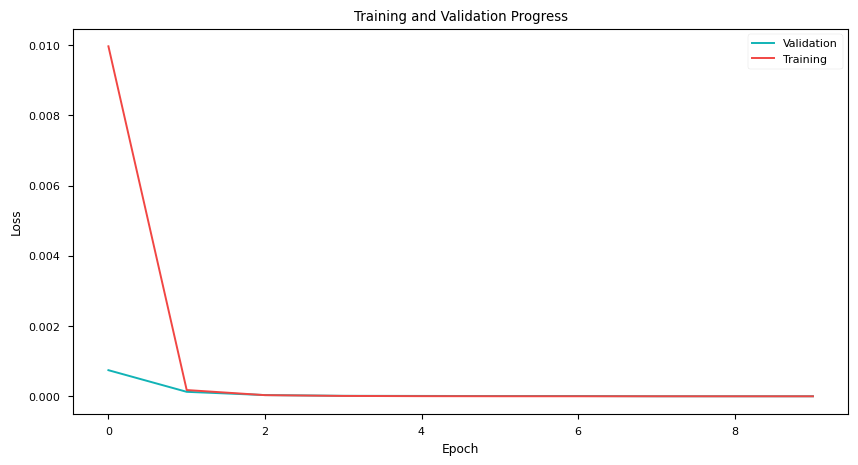

In [155]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [16]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 3,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

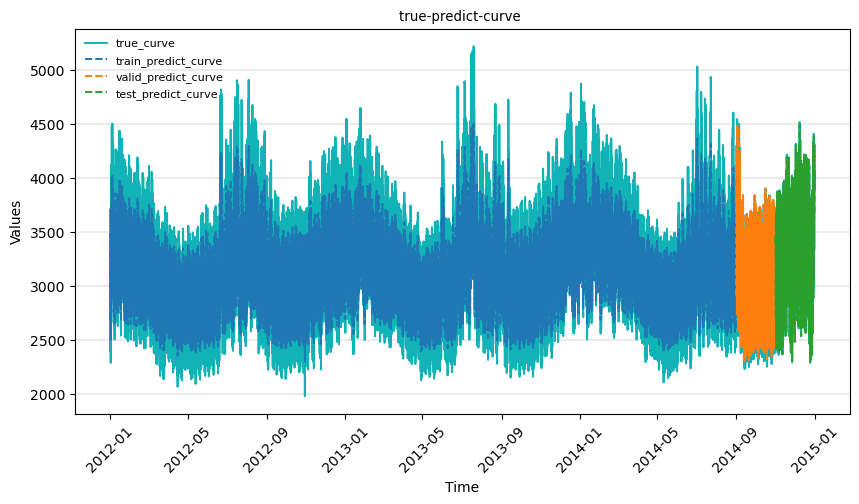

In [17]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

In [18]:
# # 全局动态图
# params6 = {
#     "timeseries_x": timeseries_x,
#     "timeseries_y": timeseries_y,
#     "train_plot_x": train_plot_x,
#     "train_plot_y": train_plot_y,
#     "valid_plot_x": valid_plot_x,
#     "valid_plot_y": valid_plot_y,
#     "test_plot_x": test_plot_x,
#     "test_plot_y": test_plot_y,
# }
# dynamic_full_timeseries(**params6)

In [19]:
# # 局部动态图
# params6 = {
#     "timeseries_x": timeseries_x,
#     "timeseries_y": timeseries_y,
#     "test_plot_x": test_plot_x,
#     "test_plot_y": test_plot_y,
# }
# dynamic_part_timeseries(**params6)

### Bi-GRU-AD

In [16]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义编码器模型
    class Encoder(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Encoder, self).__init__()
            # GRU层将输入序列映射到隐藏状态空间，双向GRU
            self.gru = nn.GRU(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)

        def forward(self, x):
            # 将输入序列传入GRU层，返回隐藏状态
            _, hidden = self.gru(x)
            return hidden

    # 定义解码器模型
    class Decoder(nn.Module):
        def __init__(self, hidden_dim, out_dim):
            super(Decoder, self).__init__()
            # GRU层将解码器输入映射到隐藏状态空间
            self.gru = nn.GRU(out_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)
            # dropout操作层
            self.dropout = nn.Dropout(0.1)
            # 线性层将解码器输出映射到指定输出维度，线性层输入维度为hidden_dim*2
            self.out = nn.Linear(hidden_dim*2, out_dim)

        def forward(self, y, hidden):
            # 将输入序列传入GRU层，返回输出、隐藏状态
            output, hidden = self.gru(y, hidden)
            output = self.dropout(output)
            # 使用线性层映射到输出维度
            output = self.out(output)
            return output, hidden

    # 定义整个Seq2Seq模型
    class Seq2Seq(nn.Module):
        def __init__(self, input_dim, hidden_dim, out_dim):
            super(Seq2Seq, self).__init__()
            # 创建编码器和解码器实例
            self.encoder = Encoder(input_dim, hidden_dim)
            self.decoder = Decoder(hidden_dim, out_dim)

        def forward(self, x, y):
            # 编码器处理输入序列
            encoder_hidden = self.encoder(x)
            # 解码器初始化隐藏状态，让解码器的隐藏层状态等于编码器的隐藏层状态
            decoder_hidden = encoder_hidden
            # 解码器处理目标序列
            decoder_output, _ = self.decoder(y, decoder_hidden)
            return decoder_output
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    model = Seq2Seq(input_dim=2, hidden_dim=20, out_dim=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch, targets_batch)
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch, targets_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:05<00:46,  5.21s/it]

Epoch [1/10], Training Loss: 0.0083, Validation Loss: 0.0004


 20%|████████████████▌                                                                  | 2/10 [00:10<00:41,  5.22s/it]

Epoch [2/10], Training Loss: 0.0011, Validation Loss: 0.0001


 30%|████████████████████████▉                                                          | 3/10 [00:15<00:37,  5.30s/it]

Epoch [3/10], Training Loss: 0.0008, Validation Loss: 0.0000


 40%|█████████████████████████████████▏                                                 | 4/10 [00:21<00:31,  5.33s/it]

Epoch [4/10], Training Loss: 0.0006, Validation Loss: 0.0000


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:26<00:26,  5.34s/it]

Epoch [5/10], Training Loss: 0.0005, Validation Loss: 0.0000


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:31<00:21,  5.34s/it]

Epoch [6/10], Training Loss: 0.0003, Validation Loss: 0.0001


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:37<00:15,  5.30s/it]

Epoch [7/10], Training Loss: 0.0002, Validation Loss: 0.0000


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:42<00:10,  5.31s/it]

Epoch [8/10], Training Loss: 0.0002, Validation Loss: 0.0000


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:47<00:05,  5.29s/it]

Epoch [9/10], Training Loss: 0.0001, Validation Loss: 0.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.29s/it]

Epoch [10/10], Training Loss: 0.0001, Validation Loss: 0.0000


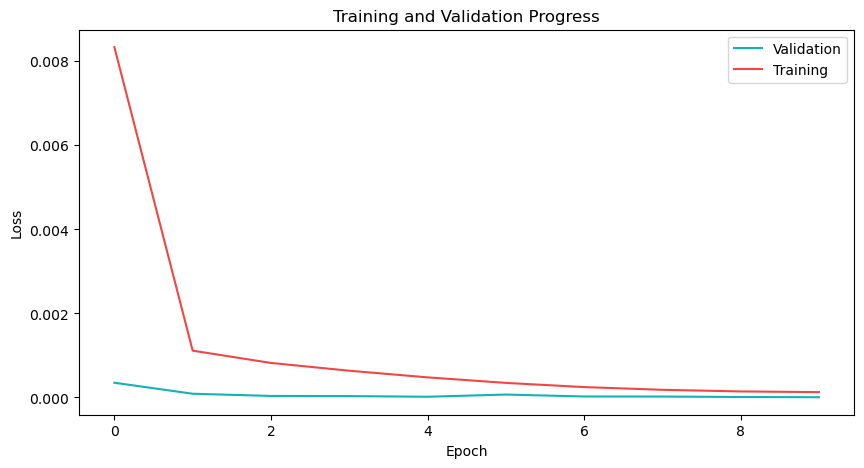

In [17]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [22]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 3,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

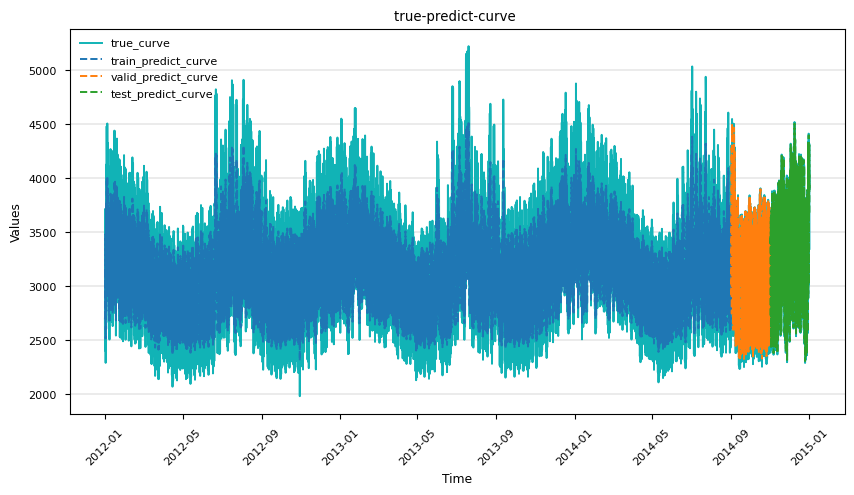

In [23]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

### Transformer

详见时间序列预测Ⅴ。

## Autoencoder

### 数据准备

In [68]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [69]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [70]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load", "temp"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


### 线性自编码器

In [6]:
# 生成tensor数据
def create_dataset(feature, target, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    #转为张量
    X = torch.as_tensor(feature)
    y = torch.as_tensor(target)
    
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [7]:
# 构造参数字典
params2 = {
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23376, 2]),y_size: torch.Size([23376, 2]),loader_len: 731
X_size: torch.Size([1464, 2]),y_size: torch.Size([1464, 2]),loader_len: 46
X_size: torch.Size([1464, 2]),y_size: torch.Size([1464, 2]),loader_len: 46


In [8]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义自编码器模型
    class Autoencoder(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Autoencoder, self).__init__()
            self.encoder = nn.Linear(input_dim, hidden_dim)
            self.decoder = nn.Linear(hidden_dim, input_dim)

        def forward(self, x):
            x = self.encoder(x)
            x = torch.relu(x)
            x = self.decoder(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    model = Autoencoder(input_dim=2, hidden_dim=93).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.48it/s]

Epoch [1/10], Training Loss: 0.0143, Validation Loss: 0.0005


 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Training Loss: 0.0000, Validation Loss: 0.0003


 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.52it/s]

Epoch [3/10], Training Loss: 0.0000, Validation Loss: 0.0003


 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.54it/s]

Epoch [4/10], Training Loss: 0.0000, Validation Loss: 0.0002


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.51it/s]

Epoch [5/10], Training Loss: 0.0000, Validation Loss: 0.0002


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.47it/s]

Epoch [6/10], Training Loss: 0.0000, Validation Loss: 0.0002


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.49it/s]

Epoch [7/10], Training Loss: 0.0000, Validation Loss: 0.0002


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.49it/s]

Epoch [8/10], Training Loss: 0.0000, Validation Loss: 0.0001


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.48it/s]

Epoch [9/10], Training Loss: 0.0000, Validation Loss: 0.0001


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]

Epoch [10/10], Training Loss: 0.0000, Validation Loss: 0.0001


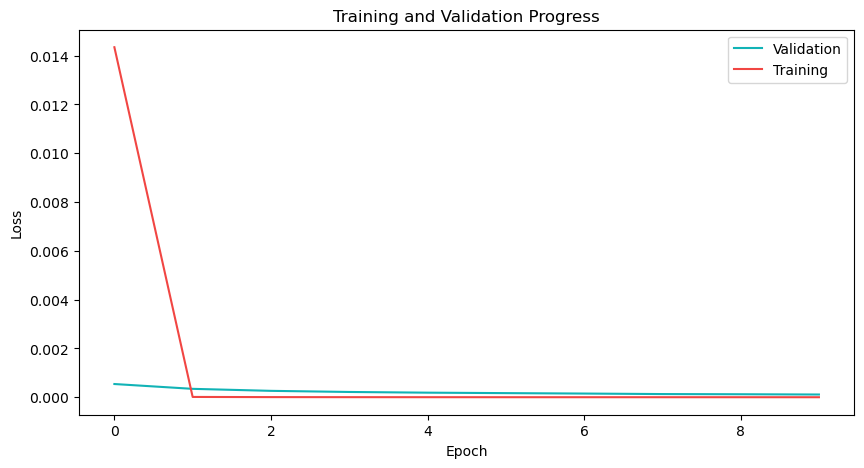

In [15]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [16]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, scaler):
    # 数据集长度
    train_size = len(X_train)
    valid_size = len(X_valid)
    test_size = len(X_test)
    
    # 时间序列形状
    timeseries_y = list(y_true.values.astype('float32').reshape(-1, ))
    timeseries_x = list(np.array(y_true.index).reshape(-1, ))
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred = model(X_train)
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) # 反归一化
        train_plot_y = y_pred[:, 0] # 0表示第一个输出
        train_plot_x = list(timeseries_x[: train_size])
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = y_pred[:, 0] # 0表示第一个输出
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = y_pred[:, 0] # 0表示第一个输出
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [17]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data[['load']],
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

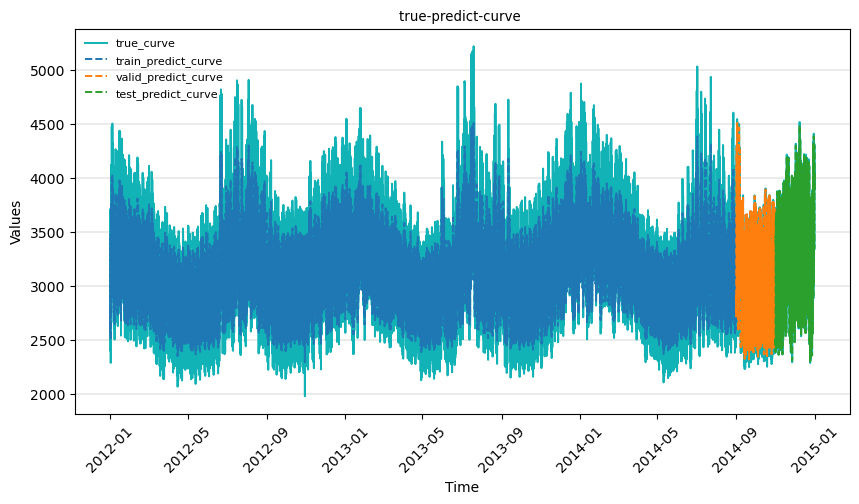

In [18]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

### 循环自编码器

基于LSTM的自编码器(LSTM-AE)中，输入和输出的时间步通常应该是一致的。自编码器的目标是通过编码和解码学习数据的表示，而LSTM是一种逐步处理序列数据的模型，需要保持输入和输出序列的长度一致以便进行有效的训练和预测。

In [60]:
# 生成tensor数据
def rnn_create_dataset(feature, target, lookback, step, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    X, y = [], []
    #循环生成数据
    for i in range(lookback, len(feature), step):
        feat = feature[i - lookback:i]
        tar = target[i - lookback:i]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [61]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "step": 1,
    "batch_size": 64,
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 2]),y_size: torch.Size([23370, 6, 2]),loader_len: 366
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 23
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 23


In [62]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义编码器模型
    class Encoder(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Encoder, self).__init__()
            # LSTM层将输入序列映射到隐藏状态空间，双向LSTM
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)

        def forward(self, x):
            # 将输入序列传入LSTM层，返回隐藏状态和细胞状态
            _, (hidden, cell) = self.lstm(x)
            return hidden, cell

    # 定义解码器模型
    class Decoder(nn.Module):
        def __init__(self, hidden_dim, input_dim):
            super(Decoder, self).__init__()
            # LSTM层将解码器输入映射到隐藏状态空间
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)
            # 线性层将解码器输出映射到指定输出维度，线性层输入维度为hidden_dim*2
            self.out = nn.Linear(hidden_dim*2, input_dim)

        def forward(self, y, hidden, cell):
            # 将输入序列传入LSTM层，返回输出、隐藏状态和细胞状态
            output, (hidden, cell) = self.lstm(y, (hidden, cell))
            # 使用线性层映射到输出维度
            output = self.out(output)
            return output, hidden, cell

    # 定义整个Seq2Seq模型
    class Seq2Seq(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Seq2Seq, self).__init__()
            # 创建编码器和解码器实例
            self.encoder = Encoder(input_dim, hidden_dim)
            self.decoder = Decoder(hidden_dim, input_dim)

        def forward(self, x, y):
            # 编码器处理输入序列
            encoder_hidden, encoder_cell = self.encoder(x)
            # 解码器初始化隐藏状态和细胞状态，让解码器的隐藏层状态等于编码器的隐藏层状态
            decoder_hidden, decoder_cell = encoder_hidden, encoder_cell
            # 解码器处理目标序列
            decoder_output, _, _ = self.decoder(y, decoder_hidden, decoder_cell)
            return decoder_output
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    model = Seq2Seq(input_dim=2, hidden_dim=1).to(device) # hidden_dim如果小于input_dim，可以达到降维效果
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch, targets_batch)
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch, targets_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:01<00:15,  1.69s/it]

Epoch [1/10], Training Loss: 0.1878, Validation Loss: 0.0478


 20%|████████████████▌                                                                  | 2/10 [00:03<00:13,  1.64s/it]

Epoch [2/10], Training Loss: 0.0284, Validation Loss: 0.0340


 30%|████████████████████████▉                                                          | 3/10 [00:04<00:11,  1.63s/it]

Epoch [3/10], Training Loss: 0.0177, Validation Loss: 0.0274


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:10,  1.67s/it]

Epoch [4/10], Training Loss: 0.0160, Validation Loss: 0.0255


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:08<00:08,  1.70s/it]

Epoch [5/10], Training Loss: 0.0150, Validation Loss: 0.0225


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:10<00:06,  1.74s/it]

Epoch [6/10], Training Loss: 0.0106, Validation Loss: 0.0108


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:12<00:05,  1.77s/it]

Epoch [7/10], Training Loss: 0.0042, Validation Loss: 0.0058


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:03,  1.77s/it]

Epoch [8/10], Training Loss: 0.0019, Validation Loss: 0.0031


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:15<00:01,  1.80s/it]

Epoch [9/10], Training Loss: 0.0009, Validation Loss: 0.0021


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0017


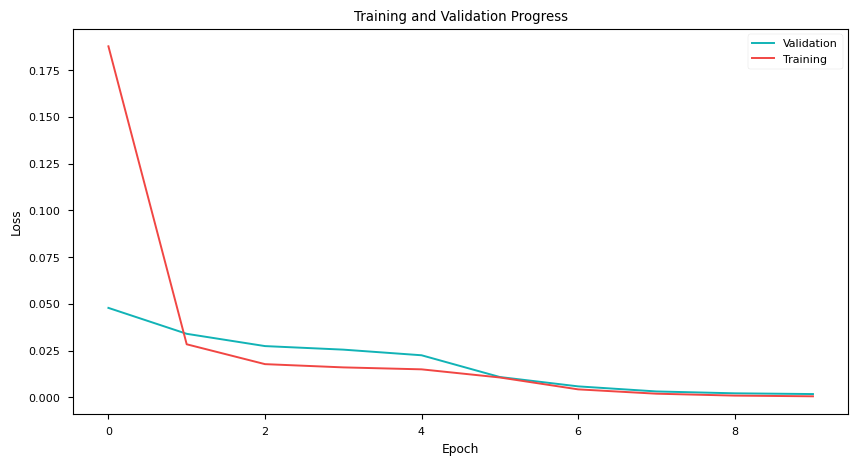

In [63]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [64]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, scaler):
    # 数据集长度
    train_size = len(X_train) + lookback
    valid_size = len(X_valid) + lookback
    test_size = len(X_test) + lookback
    
    # 时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred = model(X_train, y_train)
        y_pred = y_pred[:, -1, :]
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred)[:, 0] # 反归一化
        train_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred = model(X_valid, y_valid)
        y_pred = y_pred[:, -1, :]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)[:, 0]
        valid_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test, y_test)
        y_pred = y_pred[:, -1, :]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)[:, 0]
        test_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [65]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

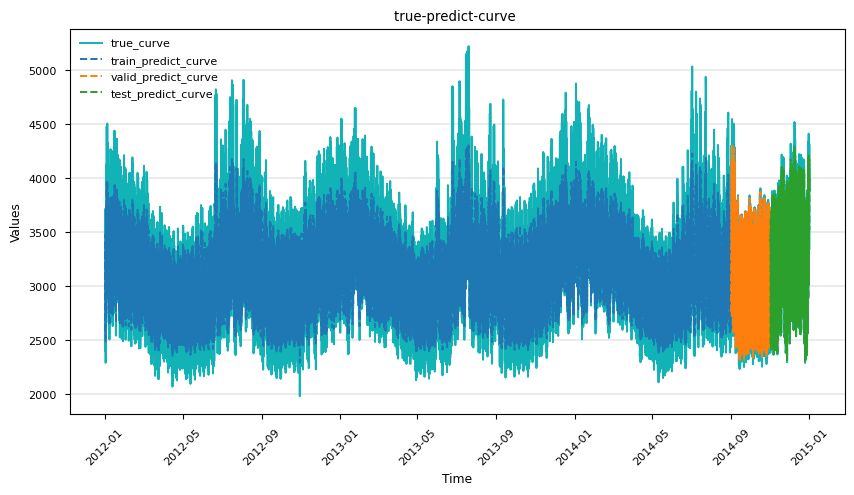

In [66]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

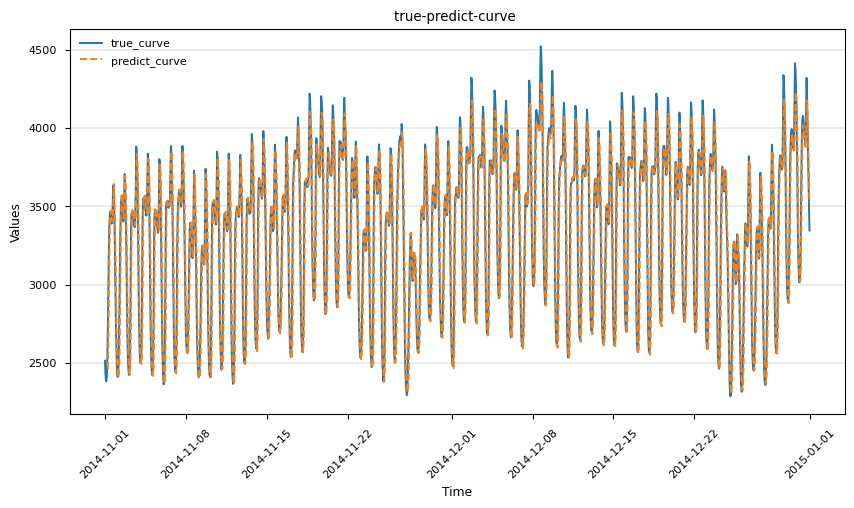

In [67]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)

### 卷积自编码器

In [124]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load", "temp"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [125]:
# 生成tensor数据
def cnn_create_dataset(feature, target, lookback, step, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    X, y = [], []
    #循环生成数据
    for i in range(lookback, len(feature), step):
        feat = feature[i - lookback:i]
        tar = target[i - lookback:i]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    X = X.permute(0,2,1)
    y = y.permute(0,2,1)
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [126]:
# 构造参数字典
params2 = {
    "lookback": 64,
    "step": 1,
    "batch_size": 32,
}
X_train, y_train, train_loader = cnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = cnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = cnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23312, 2, 64]),y_size: torch.Size([23312, 2, 64]),loader_len: 729
X_size: torch.Size([1400, 2, 64]),y_size: torch.Size([1400, 2, 64]),loader_len: 44
X_size: torch.Size([1400, 2, 64]),y_size: torch.Size([1400, 2, 64]),loader_len: 44


In [135]:
def train(train_loader, valid_loader, n_epochs, input_dim, seq_length, hidden_dim, verbose=True, plots=True):
    # 定义一维卷积编码器
    class Encoder(nn.Module):
        def __init__(self, input_dim, seq_length, hidden_dim):
            super(Encoder, self).__init__()
            self.conv1 = nn.Conv1d(input_dim, 16, kernel_size=3, stride=2, padding=1) # stride=2使序列长度减半
            self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1)
            self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1) # 形状为（batch_size, 64, 8）
            # 将多维的输入数据展平为一维
            self.flatten = nn.Flatten()
            self.fc = nn.Linear(64 * (seq_length // (2*2*2)), hidden_dim) # 序列长度大于8

        def forward(self, x):
            x = nn.functional.relu(self.conv1(x))
            x = nn.functional.relu(self.conv2(x))
            x = nn.functional.relu(self.conv3(x))
            x = self.flatten(x)
            x = self.fc(x)
            return x

    # 定义一维卷积解码器
    class Decoder(nn.Module):
        def __init__(self, input_dim, hidden_dim, seq_length):
            super(Decoder, self).__init__()
            self.fc = nn.Linear(hidden_dim, 64 * (seq_length // (2*2*2)))
            # 反卷积
            self.deconv1 = nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1,
                                              groups=2)  # groups 参数指定了输入通道分组的数量，等于通道数
            self.deconv2 = nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, 
                                              groups=2)  # 添加 groups 参数
            self.deconv3 = nn.ConvTranspose1d(16, input_dim, kernel_size=3, stride=2, padding=1, output_padding=1) 

        def forward(self, x):
            x = self.fc(x)
            x = x.view(x.size(0), 64, -1) # 形状还原
            x = nn.functional.relu(self.deconv1(x))
            x = nn.functional.relu(self.deconv2(x))
            x = self.deconv3(x)
            return x

    # 定义一维卷积自编码器
    class Seq2Seq(nn.Module):
        def __init__(self, input_dim, seq_length, hidden_dim):
            super(Seq2Seq, self).__init__()
            self.encoder = Encoder(input_dim, seq_length, hidden_dim)
            self.decoder = Decoder(input_dim, hidden_dim, seq_length)

        def forward(self, x):
            x = self.encoder(x) 
            x = self.decoder(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    model = Seq2Seq(input_dim=input_dim, seq_length=seq_length, hidden_dim=hidden_dim).to(device) # hidden_dim如果小于input_dim，可以达到降维效果
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:05<00:48,  5.41s/it]

Epoch [1/10], Training Loss: 0.0216, Validation Loss: 0.0047


 20%|████████████████▌                                                                  | 2/10 [00:11<00:47,  5.96s/it]

Epoch [2/10], Training Loss: 0.0009, Validation Loss: 0.0027


 30%|████████████████████████▉                                                          | 3/10 [00:17<00:41,  5.91s/it]

Epoch [3/10], Training Loss: 0.0006, Validation Loss: 0.0020


 40%|█████████████████████████████████▏                                                 | 4/10 [00:23<00:35,  5.92s/it]

Epoch [4/10], Training Loss: 0.0005, Validation Loss: 0.0017


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:29<00:29,  5.92s/it]

Epoch [5/10], Training Loss: 0.0004, Validation Loss: 0.0016


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:35<00:24,  6.03s/it]

Epoch [6/10], Training Loss: 0.0004, Validation Loss: 0.0015


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:41<00:17,  5.96s/it]

Epoch [7/10], Training Loss: 0.0003, Validation Loss: 0.0015


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:47<00:12,  6.07s/it]

Epoch [8/10], Training Loss: 0.0003, Validation Loss: 0.0014


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:54<00:06,  6.22s/it]

Epoch [9/10], Training Loss: 0.0003, Validation Loss: 0.0014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.03s/it]

Epoch [10/10], Training Loss: 0.0002, Validation Loss: 0.0014


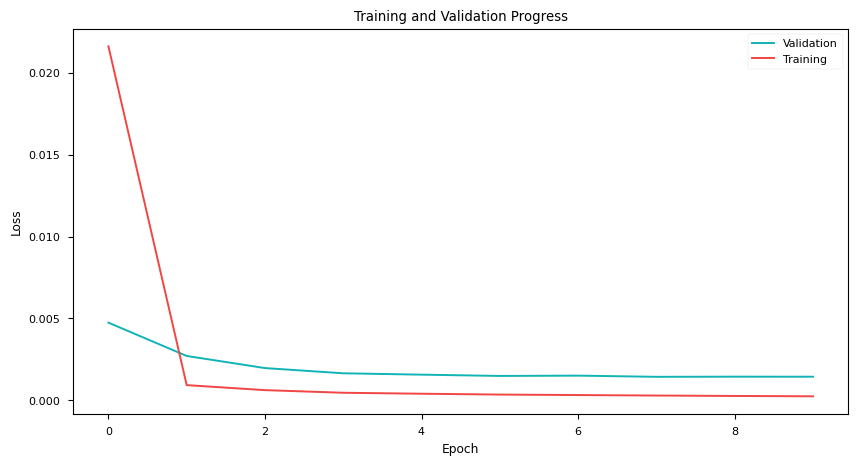

In [136]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 2,
    "seq_length": 64,
    "hidden_dim": 32,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [149]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, scaler):
    # 数据集长度
    train_size = len(X_train) + lookback
    valid_size = len(X_valid) + lookback
    test_size = len(X_test) + lookback
    
    # 时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred = model(X_train)
        y_pred = y_pred[:, :, -1] # 取最后一个输出
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred)[:, 0] # 反归一化，并取第一个特征
        train_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred[:, :, -1]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)[:, 0]
        valid_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred[:, :, -1]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)[:, 0]
        test_plot_y = [np.nan]*(lookback) + list(y_pred.reshape(-1, ))
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [150]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data[['load']],
    "lookback": 64,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

torch.Size([23312, 2, 64])


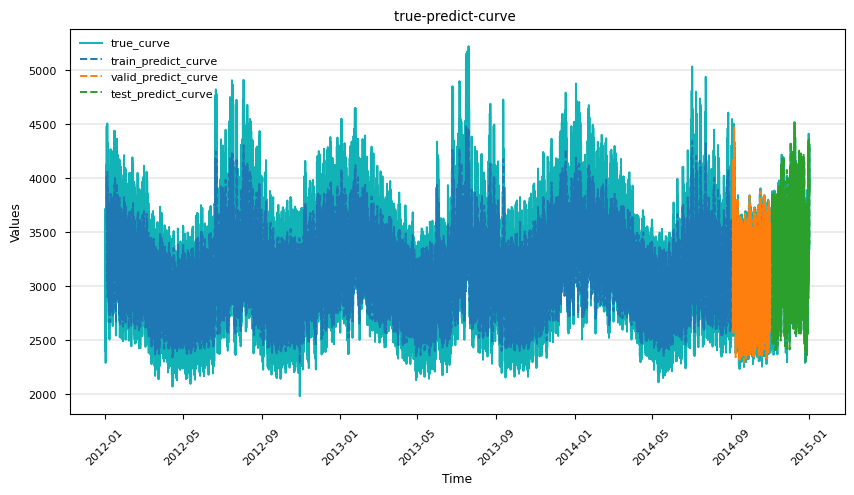

In [151]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

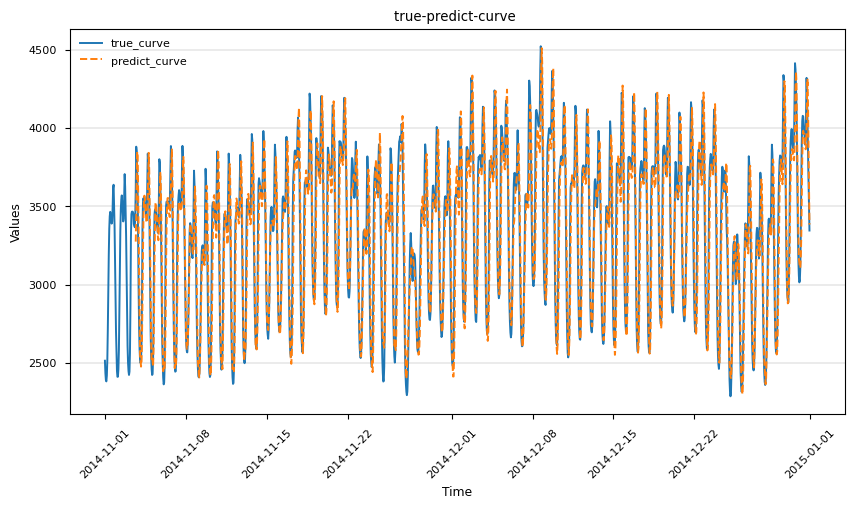

In [152]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)